In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from astroquery.vizier import Vizier
vizier = Vizier(row_limit=-1)

In [3]:
catalog = vizier.query_constraints(catalog='J/A+A/705/A5/oc-list', columns=['*'], TOI=str('TOI-1690'))

In [4]:
expected_times = np.array(catalog[0]['TimePred'])
print(expected_times.shape)

(348,)


Open each file in tess_data, get earliest and latest time in BJD (not TBJD), compare to expected_times.

In [5]:
from astropy.io import fits

In [6]:
tess_bjds = []
pdcsap_fluxes = []

base_dir = '/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/tess_data'
for filename in os.listdir(base_dir):
    filepath = os.path.join(base_dir, filename, f'{filename}_lc.fits')

    try:
        with fits.open(filepath, mode="readonly") as hdulist:
            tess_bjds.append(hdulist[1].data['TIME'])
            pdcsap_fluxes.append(hdulist[1].data['PDCSAP_FLUX'])
    except FileNotFoundError:
        print(filepath)

tess_bjds = np.concatenate(tess_bjds)
pdcsap_fluxes = np.concatenate(pdcsap_fluxes)

/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/tess_data/tess2019199201929-s0014-s0050-0000000267574918/tess2019199201929-s0014-s0050-0000000267574918_lc.fits
/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/tess_data/tess2024196212429-s0081-0000000267574918-0276-a_fast/tess2024196212429-s0081-0000000267574918-0276-a_fast_lc.fits
/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/tess_data/tess2024326142117-s0086-0000000267574918-0283-a_fast/tess2024326142117-s0086-0000000267574918-0283-a_fast_lc.fits
/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/tess_data/tess2022164095748-s0053-0000000267574918-0226-a_fast/tess2022164095748-s0053-0000000267574918-0226-a_fast_lc.fits
/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/tess_data/tess2023341045131-s0073-0000000267574918-0268-a_fast/tess2023341045131-s0073-0000000267574918-0268-a_fast_lc.fits
/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-53

In [7]:
sort_idx = np.argsort(tess_bjds)
tess_bjds = tess_bjds[sort_idx]
pdcsap_fluxes = pdcsap_fluxes[sort_idx]

valid_mask = ~np.isnan(tess_bjds) & ~np.isnan(pdcsap_fluxes)
tess_bjds = tess_bjds[valid_mask]
pdcsap_fluxes = pdcsap_fluxes[valid_mask]

In [8]:
P = 1.407939211 
t0 =  2458779.375083
folded_times = tess_bjds % P
midtransit_time = (t0 - 2457000) % P
folded_times -= midtransit_time
folded_times *= 24 * 60 # convert days to minutes

In [9]:
sorted_times = np.sort(tess_bjds) + 2457000
print(np.min(sorted_times), np.max(sorted_times))

2458683.3553905166 2460662.8250468103


In [10]:
print(np.sum(np.logical_and(expected_times > np.min(sorted_times), expected_times < np.max(sorted_times))))

348


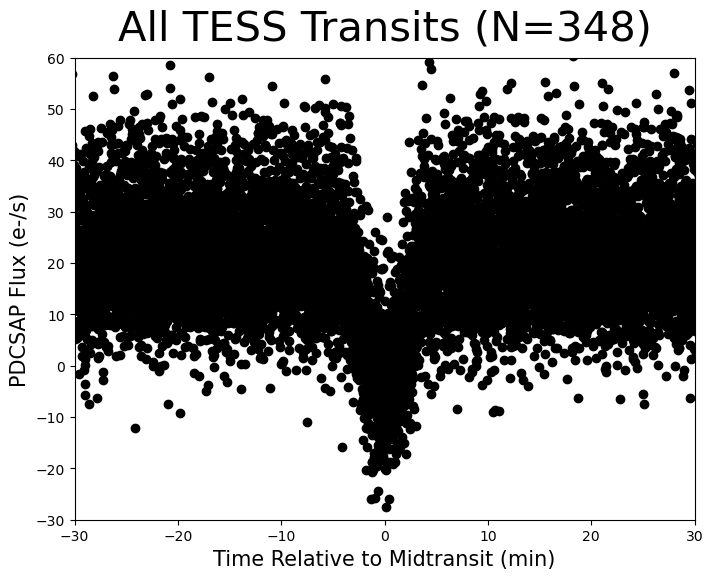

In [11]:
num_avg = [1, 5, 10, 20]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=0.3)

ax.plot(folded_times, pdcsap_fluxes, 'ko')

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 60)
ax.set_ylabel('PDCSAP Flux (e-/s)', fontsize=15)

ax.set_xlabel('Time Relative to Midtransit (min)', fontsize=15)
ax.set_title('All TESS Transits (N=348)', fontsize=30, y=1.02);

Plot light curve from our best fit parameters and with Naponiello's parameters

In [12]:
import sys
sys.path.append('../fit_lightcurves')

In [13]:
import model_transits

In [14]:
rho_star_cgs = 292503
m_star_cgs = 5.2 * 1.899e30

# rho_star = m_star / (4/3 pi r_star^3)
r_star_cgs = (m_star_cgs / (4/3 * np.pi * rho_star_cgs))**(1/3)
a_cgs = 0.0204 * 1.496e13
r_a = r_star_cgs / a_cgs

In [15]:
print(r_a)

0.0006569636851833052


In [16]:
times = np.linspace(-0.02, 0.02, 10000)

t0, b, r_a, Rp_Rs, u1, u2 =  0.0, 8.3, 0.00294, 8.4, 0.52, 0.52
our_model = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, P, times)

t0, b, r_a, Rp_Rs, u1, u2 =  0.0, 6.53, r_a, 6.82, 0.52, 0.52
naponiello_model = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, P, times)

/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/tess_2/../fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


In [17]:
plt.rcParams['font.family'] = 'serif'


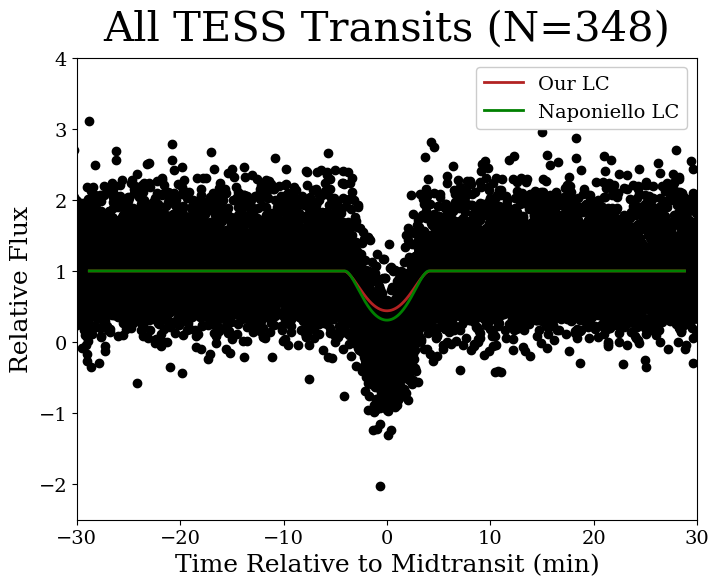

In [20]:
num_avg = [1, 5, 10, 20]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=0.3)

ax.plot(folded_times, rel_flux, 'ko', zorder=1)

ax.plot(times*(24*60), our_model, linestyle='-', color='firebrick', zorder=3, label='Our LC', linewidth=2)
ax.plot(times*(24*60), naponiello_model, linestyle='-', color='green', zorder=3, label='Naponiello LC', linewidth=2)

ax.set_xlim(-30, 30)
ax.set_ylim(-2.5, 4)
ax.set_ylabel('Relative Flux', fontsize=18)

ax.set_xlabel('Time Relative to Midtransit (min)', fontsize=18)

ax.set_title('All TESS Transits (N=348)', fontsize=30, y=1.02)
ax.legend(loc='upper right', fontsize=14, framealpha=1)
ax.tick_params(axis='both', labelsize=14)

savepath = '/Users/eligendreaudistler/Desktop/TESS_LC_Comparison.jpg'
plt.savefig(savepath, format='jpg', bbox_inches='tight');

Fit light curve to above plot

In [ ]:
import sys
sys.path.append('../fit_lightcurves')
import model_transits
from scipy.optimize import minimize
import multiprocessing
import emcee

In [ ]:
# initial guesses
t0_true = 0.0
b_true = 7.16 # from Vanderburg
r_a_true = 0.002986 # calculated as 0.01310 R✶(R⦿) x (0.00465047 au / 1 R⦿) x (1 orbital distance / 0.0204 au), both intermediate values from Vanderburg
r_a_true *= 1000 # normalization
Rp_Rs_true = 7.28 # from Vanderburg
u1_true = 0.059928009 # R filter
u2_true = 0.41764400

log_f_true = np.log(0.01)
theta_initial = np.array([t0_true, b_true, r_a_true, Rp_Rs_true, log_f_true, u1_true, u2_true]) # remove m, c

In [19]:
rel_flux = pdcsap_fluxes / np.median(pdcsap_fluxes)
bjd_tdb = folded_times/(24*60)

In [ ]:
def plot_lightcurve(period, bjd_tdb, rel_flux, title, theta=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    title_size = 20
    fontsize = 15

    ax.plot(bjd_tdb, rel_flux, linewidth=1.5,
                linestyle='', marker='o', markersize=4, color='crimson')
    ax.set_title(title, fontsize=title_size, y=1.01)

    if theta is not None:
        t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta
        times = np.arange(-0.005, 0.005, 0.0001)
        model = model_transits.modeltransit([t0, b, r_a/1000, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, times)
        plt.plot(times, model, markersize=3, color='black', zorder=3)

    ax.set_ylabel('Relative Flux', fontsize=fontsize)
    ax.set_xlabel('BJD TDB', fontsize=fontsize)
    ax.set_xlim(-0.005, 0.005)
    ax.set_ylim(-2, 3)

In [ ]:
plot_lightcurve(P, bjd_tdb, rel_flux, 'Initial', theta=theta_initial)

In [ ]:
# likelihood function for Gaussian distribution with variance underestimated by fractional amount f (https://emcee.readthedocs.io/en/stable/tutorials/line/)
def log_likelihood(theta, x, y): # x = time, y = rel_flux
    t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta
    model = model_transits.modeltransit([t0,b,r_a/1000,Rp_Rs,1,u1,u2],model_transits.occultquad,P,x)
    sigma2 = model**2 * np.exp(2*log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# negative log likelihood function
nll = lambda *args: -log_likelihood(*args)

mask = np.abs(bjd_tdb < 0.005)

soln = minimize(nll, theta_initial, args=(bjd_tdb[mask], rel_flux[mask]))

theta_ml = soln.x
t0_ml, b_ml, r_a_ml, Rp_Rs_ml, log_f_ml, u1_ml, u2_ml = theta_ml

print("Maximum likelihood estimates:")
print("t0 = {0:.5f}".format(t0_ml))
print("b = {0:.5f}".format(b_ml))
print("r_a = {0:.5f}".format(np.exp(r_a_ml)))
print("Rp_Rs = {0:.5f}".format(np.exp(Rp_Rs_ml)))
print("f = {0:.5f}".format(np.exp(log_f_ml)))
print("u1 = {0:.5f}".format(u1_ml))
print("u2 = {0:.5f}".format(u2_ml))

plot_lightcurve(P, bjd_tdb, rel_flux, 'Maximum Likelihood', theta=theta_ml)

In [ ]:
# uniform priors on all parameters
def log_prior(theta):
    t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta
    #if (bjd_tdb[start] < t0 < bjd_tdb[end] and 0.15 < b < 14.15 and 0 < r_a < 0.006*1000 
    #    and 2.3 < Rp_Rs < 12.3 and -10 < log_f < 10 and 0.0 < u1 < 1.0 and 0.0 < u2 < 1.0): #0.48 < u1 < 0.68 and 0.04 < u2 < 0.24): 
    if  (-0.0005 < t0 < 0.0005 and 5.0 < b < 9.5 and 0.002*1000 < r_a < 0.004*1000 
        and 5 < Rp_Rs < 12 and -10 < log_f < -3 and 0.0 < u1 < 1.0 and 0.0 < u2 < 1.0):
        return 0.0
    return -np.inf

In [ ]:
def log_probability(theta, x, y): # x = time, y = flux
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [ ]:
# initialize walkers in tiny Gaussian ball around ML soln
pos = soln.x + np.array([0.0001, 0.3, 0.0002*1000, 0.3, 1, 0.05, 0.05]) * np.random.randn(256, 7) # 256 walkers, 7 dimensions
nwalkers, ndim = pos.shape

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
#                                args=(bjd_tdb,rel_flux_normalized,
#                                      rel_flux_err_normalized))

#sampler.run_mcmc(pos, 5_000, progress=True);

ctx = multiprocessing.get_context("fork")
with ctx.Pool(processes=multiprocessing.cpu_count()) as pool:
      sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(bjd_tdb[mask], rel_flux[mask]), pool=pool)
      sampler.run_mcmc(pos, 5_000, progress=True)

In [ ]:
# check mean acceptance fraction and autocorrelation time
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
try:
    print("Autocorr time (per param):", sampler.get_autocorr_time())
except Exception as e:
    print("Autocorr time not estimated yet:", e)

In [ ]:
fig, axes = plt.subplots(7, figsize=(8,7), sharex=True)
samples = sampler.get_chain()
labels = ["t0","b","r_a","Rp_Rs","log(f)","u1","u2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i],"k",alpha=0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
    
axes[-1].set_xlabel("step number");

In [ ]:
import corner
flat_samples = sampler.get_chain(discard=2500, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths = [t0_ml, b_ml, r_a_ml, Rp_Rs_ml, log_f_ml, u1_ml, u2_ml]
);

In [ ]:
# compute parameters to cite
# here use 16th, 50th, and 84th percentiles
from IPython.display import Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
theta_mcmc = []
for j in np.arange(ndim):
    i = np.median(flat_samples[:, j])
    theta_mcmc = np.append(theta_mcmc,i)

print(theta_mcmc)

plot_lightcurve(P, folded_times, rel_flux, 'MCMC', theta=theta_mcmc)